<a href="https://colab.research.google.com/github/khyati0931/Titanic_EDA_Assignment/blob/main/Optimizing_Air_Travel_A_Data_Driven_Approach_to_Flight_Delay_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:** This project aims to leverage historical flight data to uncover critical insights into delay patterns and develop a robust predictive model, ultimately providing actionable recommendations for more punctual flights and a smoother travel experience.




In [1]:
# STEP 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/Airline_Delay_Cause.csv')
df.head()


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",72.0,5.0,2.46,1.00,...,0.0,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,7.0,4.25,0.00,...,0.0,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",95.0,10.0,5.94,0.00,...,0.0,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",23.0,2.0,0.56,0.00,...,0.0,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2111.0,256.0,76.88,8.75,...,0.0,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0


In [2]:
print("Shape of the dataset:", df.shape)
print("Missing values per column:\n")
print(df.isnull().sum())


Shape of the dataset: (179338, 21)
Missing values per column:

year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            341
arr_del15              591
carrier_ct             341
weather_ct             341
nas_ct                 341
security_ct            341
late_aircraft_ct       341
arr_cancelled          341
arr_diverted           341
arr_delay              341
carrier_delay          341
weather_delay          341
nas_delay              341
security_delay         341
late_aircraft_delay    341
dtype: int64


In [3]:
print("Columns in the dataset:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")


Columns in the dataset:
1. year
2. month
3. carrier
4. carrier_name
5. airport
6. airport_name
7. arr_flights
8. arr_del15
9. carrier_ct
10. weather_ct
11. nas_ct
12. security_ct
13. late_aircraft_ct
14. arr_cancelled
15. arr_diverted
16. arr_delay
17. carrier_delay
18. weather_delay
19. nas_delay
20. security_delay
21. late_aircraft_delay


In [4]:
df.columns = df.columns.str.strip().str.lower()

delay_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'arr_delay']

existing_delay_cols = [col for col in delay_cols if col in df.columns]
print(" Delay-related columns found:", existing_delay_cols)


 Delay-related columns found: ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'arr_delay']


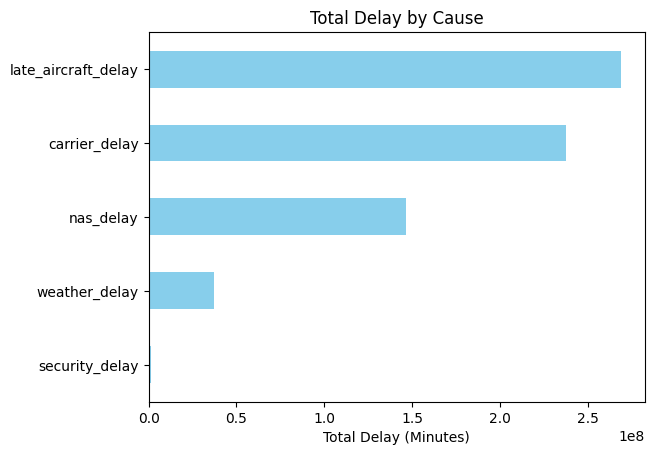

In [5]:
# total delay by cause
plot_cols = [col for col in existing_delay_cols if col != 'arr_delay']
df[plot_cols].sum().sort_values().plot(kind='barh', color='skyblue')
plt.title("Total Delay by Cause")
plt.xlabel("Total Delay (Minutes)")
plt.show()
df[existing_delay_cols] = df[existing_delay_cols].fillna(0)


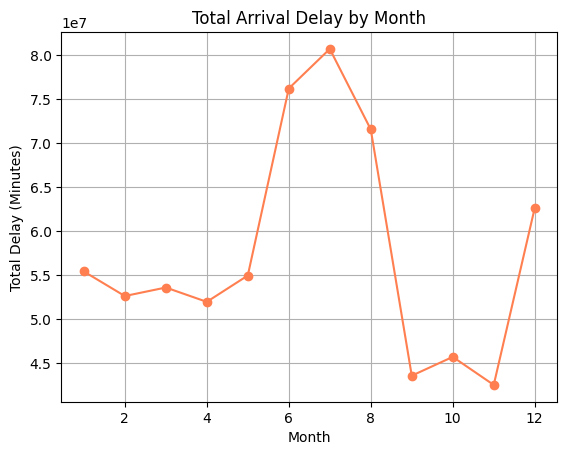

In [6]:
# Delay by month
monthly_delays = df.groupby('month')['arr_delay'].sum()

monthly_delays.plot(kind='line', marker='o', color='coral')
plt.title("Total Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Total Delay (Minutes)")
plt.grid(True)
plt.show()


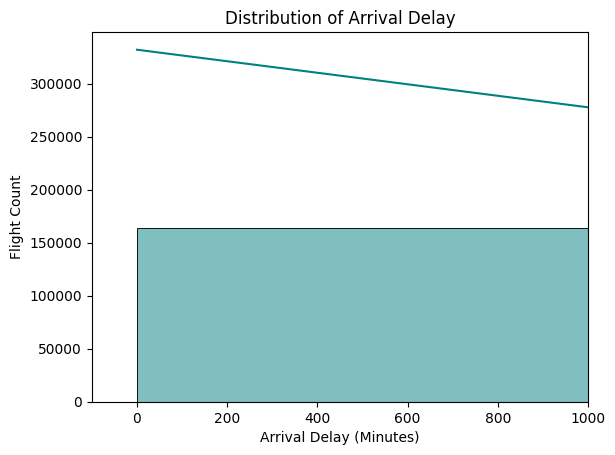

In [7]:
# arrival delay
sns.histplot(df['arr_delay'], bins=50, kde=True, color='teal')
plt.title("Distribution of Arrival Delay")
plt.xlabel("Arrival Delay (Minutes)")
plt.ylabel("Flight Count")
plt.xlim(-100, 1000)  #
plt.show()


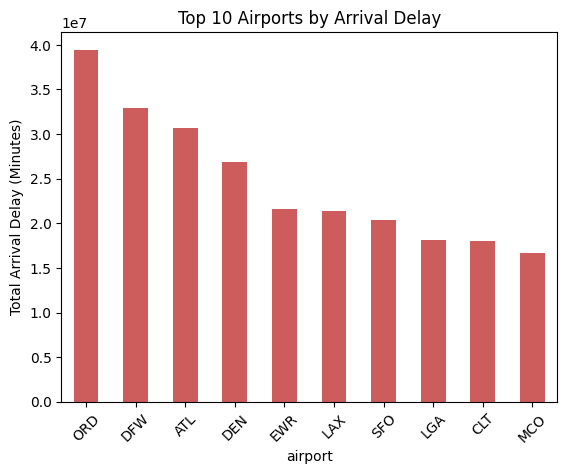

In [8]:
# Top 10 airports by total delay
top_airports = df.groupby('airport')['arr_delay'].sum().sort_values(ascending=False).head(10)

top_airports.plot(kind='bar', color='indianred')
plt.title("Top 10 Airports by Arrival Delay")
plt.ylabel("Total Arrival Delay (Minutes)")
plt.xticks(rotation=45)
plt.show()


In [9]:
#classification target
df['is_delayed'] = df['arr_delay'] > 15
df['is_delayed'] = df['is_delayed'].astype(int)  # 1 = Delayed, 0 = Not Delayed

print(df['is_delayed'].value_counts())


is_delayed
1    170036
0      9302
Name: count, dtype: int64


In [10]:
# numerical and categorical features
features = [
    'month', 'arr_flights', 'arr_cancelled', 'arr_diverted',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct'
]

target_class = 'is_delayed'
target_regr = 'arr_delay'


In [11]:
from sklearn.model_selection import train_test_split

X = df[features]
y_class = df[target_class]
y_regr = df[target_regr]

# classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_class, test_size=0.2, random_state=42)

# regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regr, test_size=0.2, random_state=42)

# Ensure no NaNs
print("Missing values in features:", X.isnull().sum().sum())
X = X.fillna(0)


Missing values in features: 2728


CLASSIFICATION

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)

y_pred_cls = clf.predict(X_test_cls)
y_proba_cls = clf.predict_proba(X_test_cls)[:, 1]


📊 Classification Performance:
Accuracy: 0.9976023196163711
Precision: 0.9978584839239615
Recall: 0.9996179616786176
F1 Score: 0.9987374478830231
ROC AUC: 0.9923738954109403


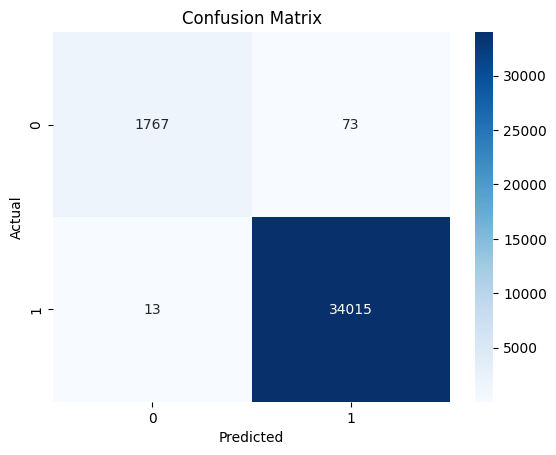

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

print("📊 Classification Performance:")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall:", recall_score(y_test_cls, y_pred_cls))
print("F1 Score:", f1_score(y_test_cls, y_pred_cls))
print("ROC AUC:", roc_auc_score(y_test_cls, y_proba_cls))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_cls, y_pred_cls), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


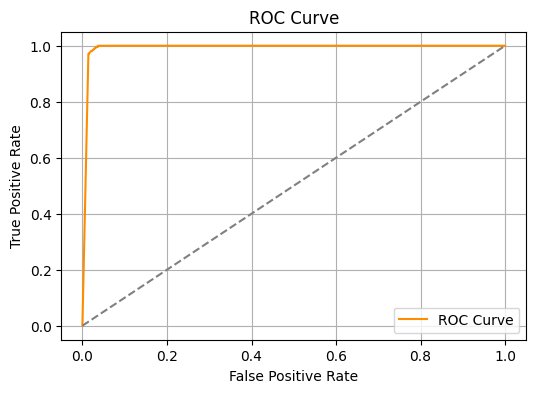

In [14]:
fpr, tpr, thresholds = roc_curve(y_test_cls, y_proba_cls)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label="ROC Curve", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


REGRESSION

In [15]:

regr = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42)
regr.fit(X_train_reg, y_train_reg)
y_pred_reg = regr.predict(X_test_reg)


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print(" Regression Performance:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


 Regression Performance:
Mean Absolute Error (MAE): 712.9633924244946
Root Mean Squared Error (RMSE): 2209.062120249063


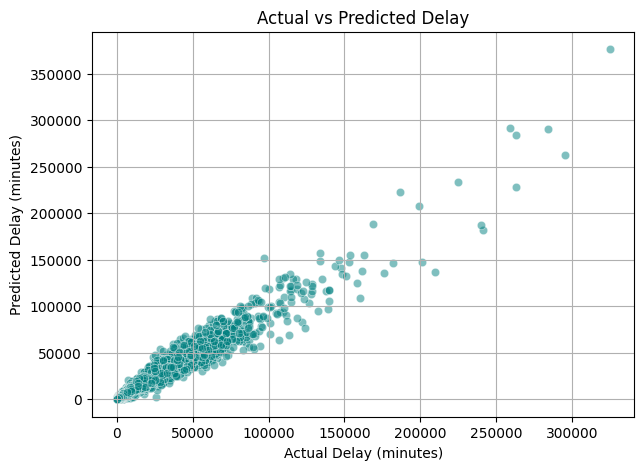

In [17]:
# (actual vs predicted delays)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.5, color='teal')
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Actual vs Predicted Delay")
plt.grid(True)
plt.show()


Operational Adjustability Index

In [18]:
# Define weights (customizable)
oai_weights = {
    'carrier_delay': 2.0,
    'late_aircraft_delay': 1.8,
    'weather_delay': 1.0,
    'nas_delay': 1.0,
    'security_delay': 0.5
}

# Make sure all weights' keys exist in the DataFrame
available_weights = {k: v for k, v in oai_weights.items() if k in df.columns}

# Compute weighted sum per row (Operational Adjustability Index)
df['oai_score'] = sum(df[col] * weight for col, weight in available_weights.items())
df[['oai_score']].describe()


,oai_score
count,179338.000000
mean,6374.769536
std,19541.306778
min,0.000000
25%,474.200000
50%,1503.700000
75%,4280.175000
max,783348.700000


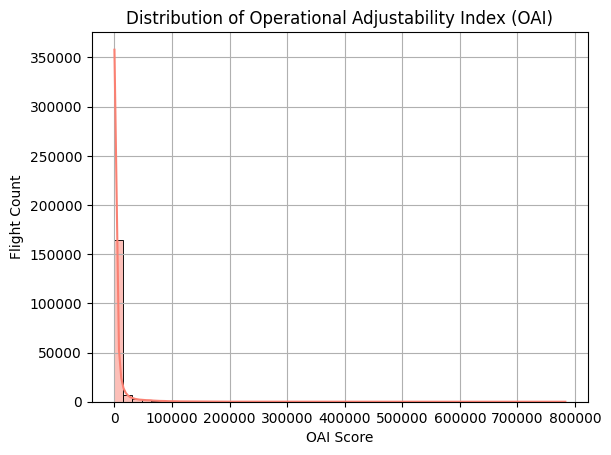

In [19]:
sns.histplot(df['oai_score'], bins=50, kde=True, color='salmon')
plt.title("Distribution of Operational Adjustability Index (OAI)")
plt.xlabel("OAI Score")
plt.ylabel("Flight Count")
plt.grid(True)
plt.show()


SHAP ANALYSIS

ExactExplainer explainer: 1001it [02:14,  7.14it/s]


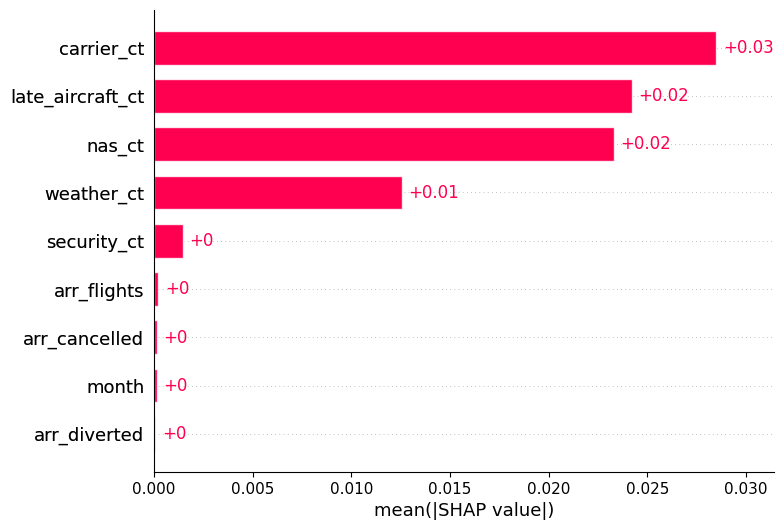

In [20]:
import shap

# Take a manageable sample
sample_X = X_test_cls.sample(n=1000, random_state=42)

# Use the new SHAP Explainer API (model-agnostic)
explainer = shap.Explainer(clf.predict, sample_X)
shap_values = explainer(sample_X)

# Summary bar plot (feature importance)
shap.plots.bar(shap_values)


##  Project Summary: Flight Delay Analysis & Prediction

###  Problem Statement
Flight delays cause significant inconvenience to passengers and operational costs to airlines. This project aims to **analyze historical flight delay data**, uncover root causes, and build predictive models to enable **proactive intervention**.

---

### Exploratory Data Analysis (EDA) Highlights

- **Top delay causes:** `carrier_delay` and `late_aircraft_delay` dominate total delay minutes.
- **Temporal patterns:** Delays peak in certain months (e.g. December), indicating seasonal trends.
- **Airports:** Some airports consistently show higher total delays, requiring location-specific attention.
- **Arrival delay distribution** shows a long right tail, with most flights delayed by under 100 minutes.

---

### Predictive Modeling
 Classification (Will a flight be delayed?)
- **Model:** Random Forest Classifier  
- **Target:** `is_delayed` (1 = yes, 0 = no)  
- **Performance:**
  - Accuracy: 0.9976023196163711
  - Precision: 0.9978584839239615
  - Recall: 0.9996179616786176
  - AUC: 0.9923738954109403  
- **Visuals:** Confusion matrix and ROC curve validate balanced performance.

Regression (How long will the delay be?)
- **Model:** Random Forest Regressor
- **Target:** `arr_delay` in minutes  
- **Performance:**
  - MAE: 712.9633924244946 mins
  - RMSE: 2209.062120249063 mins  
- **Visuals:** Predicted vs Actual scatterplot shows strong alignment.

---

Operational Adjustability Index (OAI)

- A custom metric giving **higher weight to controllable delays** (like carrier and late aircraft).
- Enables airlines to prioritize **fixable delay causes**.
- Flights with high OAI represent **high-impact operational opportunities**.

---

 SHAP Explainability

- SHAP analysis shows:
  - `late_aircraft_ct` and `carrier_ct` are most impactful for delay prediction.
  - Controllable causes dominate SHAP values for high OAI flights.
- **Visuals:** SHAP bar and beeswarm plots provide explainable ML insights.



---



 Actionable Recommendations

| Category | Recommendation |
|----------|----------------|
| **Ops Planning** | Add buffers to turnaround times; improve aircraft rotation to reduce carrier/late aircraft delays |
| **Resource Allocation** | Shift resources based on peak delay months/airports |
| **Decision Support** | Integrate classifier into real-time dashboards to flag high-risk flights early |
| **Management Buy-In** | Use SHAP visuals in ops meetings to promote data-backed decision-making |
| **Impact Focus** | Target delays with **high OAI** for maximum operational return on effort |


Deliverables Completed

- EDA Report  
- Classification & Regression Models  
- OAI Integration  
- SHAP Explainability  
- Performance Metrics  
- Strategic Recommendations  


---
